In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import  Counter
import nltk
import pickle
import string

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv("/content/spam.csv", encoding="latin-1")

In [4]:
df.sample(1)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4959,ham,I want &lt;#&gt; rs da:)do you have it?,NaN,NaN,NaN


In [5]:
df = pd.read_csv("/content/spam.csv", encoding="latin-1", usecols=["v1","v2"])

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.rename(columns={"v1": "output","v2": "input"}, inplace = True)

In [8]:
le = LabelEncoder()
df["output"] = le.fit_transform(df["output"])

In [9]:
df.shape

(5572, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   output  5572 non-null   int64 
 1   input   5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [11]:
df.isnull().sum()

output    0
input     0
dtype: int64

In [12]:
df.duplicated().sum()

403

In [13]:
df = df.drop_duplicates(keep="first")

In [14]:
df.shape

(5169, 2)

Text(0, 0.5, 'Number of Data points')

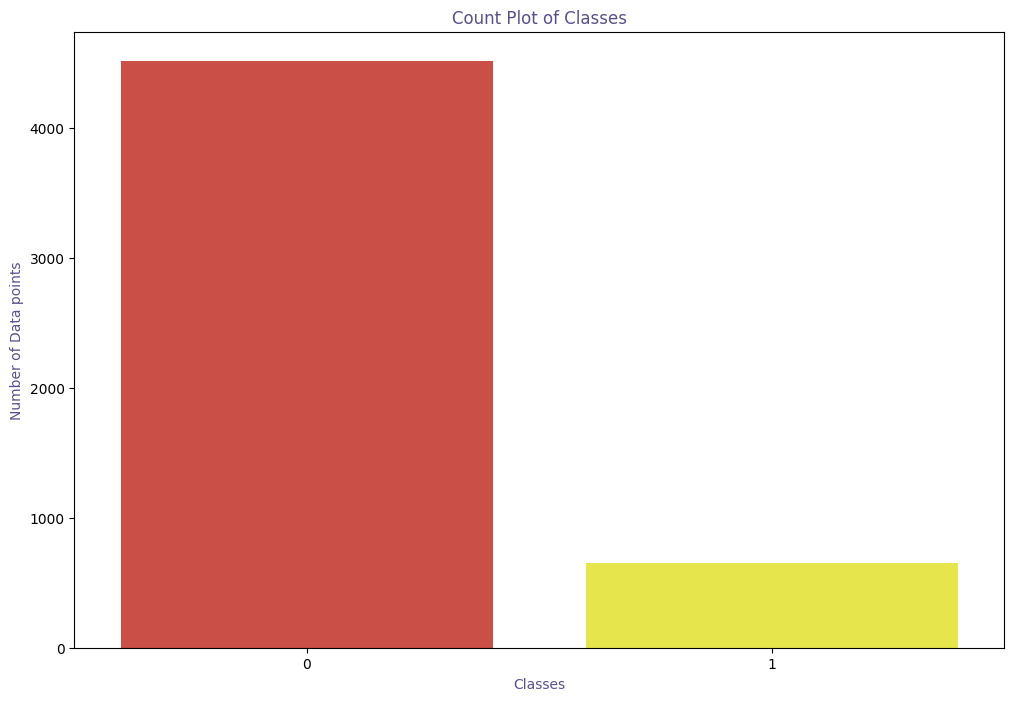

In [27]:
#Palette
cols= ["#e03c31", "#ffff33"]
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= df["output"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [28]:
df["output"].value_counts()

0    4516
1     653
Name: output, dtype: int64

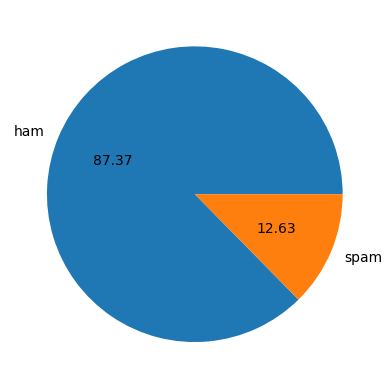

In [29]:
plt.pie(df["output"].value_counts(),autopct = "%.2f", labels=['ham','spam'])
plt.show()

In [32]:
#Adding a column of numbers of charachters,words and sentences in each msg
df["No_of_Characters"] = df["input"].apply(len)
df["No_of_Words"]=df.apply(lambda row: nltk.word_tokenize(row["input"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["input"]), axis=1).apply(len)

df.describe().T


,count,mean,std,min,25%,50%,75%,max
output,5169.0,0.126330,0.332253,0.0,0.0,0.0,0.0,1.0
No_of_Characters,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
No_of_Words,5169.0,18.455794,13.324758,1.0,9.0,15.0,26.0,220.0
No_of_sentence,5169.0,1.965564,1.448541,1.0,1.0,1.0,2.0,38.0


<Figure size 1200x800 with 0 Axes>

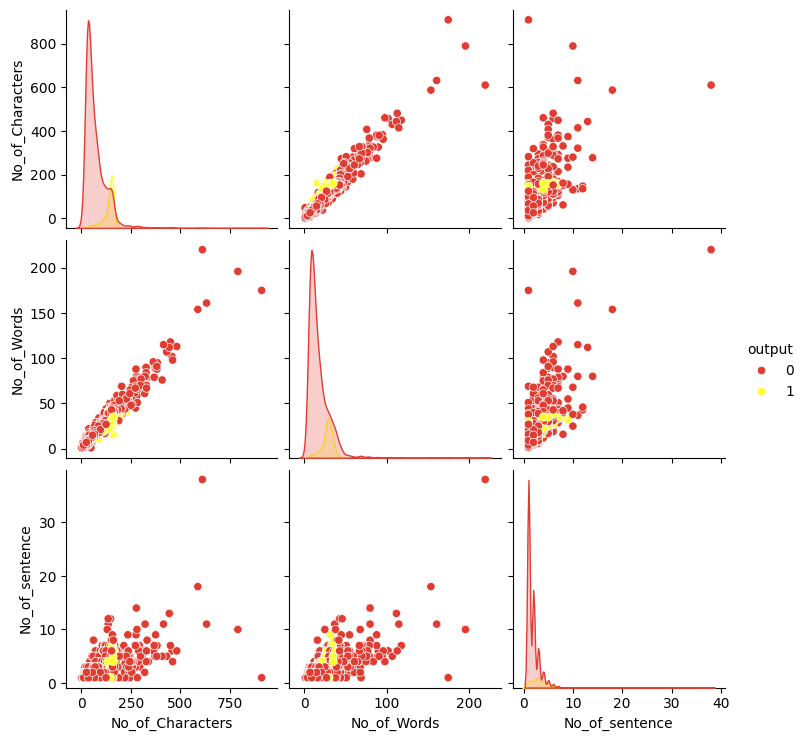

In [37]:
plt.figure(figsize=(12, 8))
sns.pairplot(data=df, hue="output", palette=cols)
plt.show()


In [40]:
#Dropping the outliers.
data= df[(df["No_of_Characters"]<350)]
df.shape

(5169, 5)

<Figure size 1200x800 with 0 Axes>

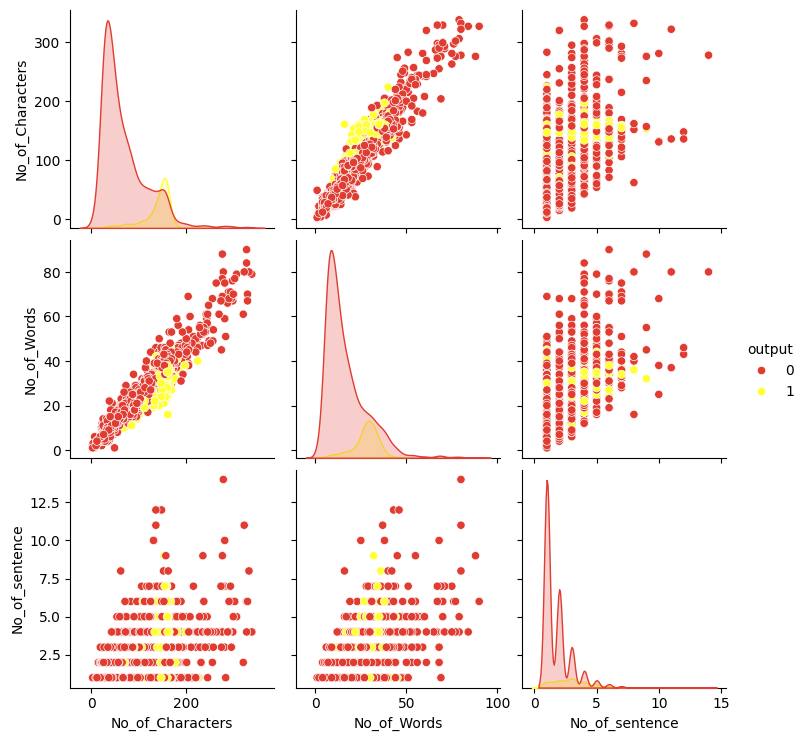

In [41]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="output",palette=cols)
plt.show(fg)

In [43]:
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["input"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [46]:
import re

# Defining a function to clean up the text
def Clean(input):
    sms = re.sub('[^a-zA-Z]', ' ', input) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["input"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")


 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [62]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [63]:
# Removing the stopwords function
def remove_stopwords(input):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in input if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


In [ ]:
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature
X.dtype

In [49]:
df["characters"] = df["input"].apply(len)

In [50]:
df["word"] = df["input"].apply(lambda x:len( nltk.word_tokenize(x)))

In [51]:
df["sentence"] = df["input"].apply(lambda x:len(nltk.sent_tokenize(x)))

In [52]:
df.head(5)

,output,input,No_of_Characters,No_of_Words,No_of_sentence,characters,word,sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,61,15,1


In [53]:
df[["characters","word", "sentence"]].describe()

,characters,word,sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [54]:
# Statistical Analysis for HAM Data
df[df["output"]==0][["characters","word", "sentence"]].describe()

,characters,word,sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [55]:
df[df["output"] ==1][["characters","word", "sentence"]].describe()

,characters,word,sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


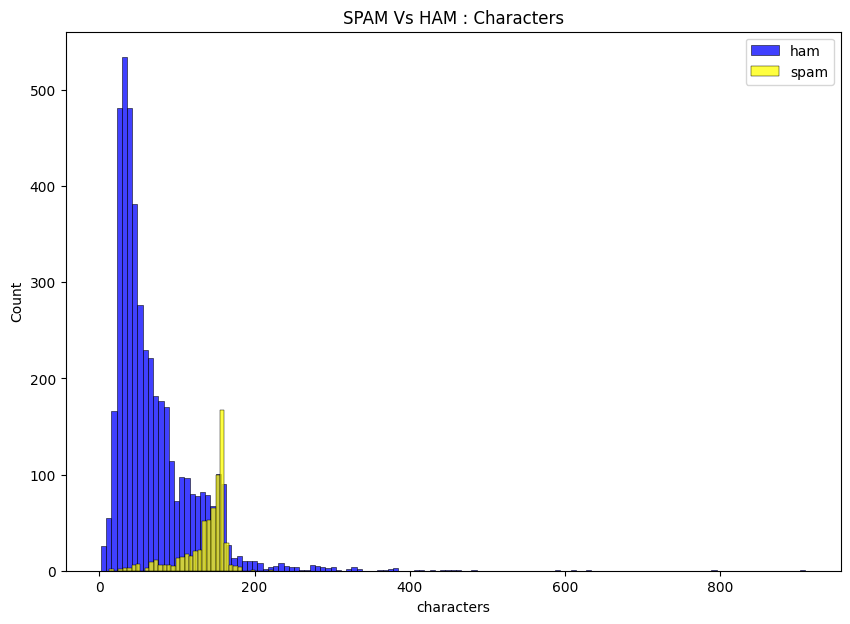

In [57]:
plt.figure(figsize=(10,7))
sns.histplot(df[df["output"]==0]["characters"],label= "ham",color="blue")
sns.histplot(df[df["output"]==1]["characters"],label= "spam",color = "yellow")
plt.title("SPAM Vs HAM : Characters")
plt.legend()
plt.show()

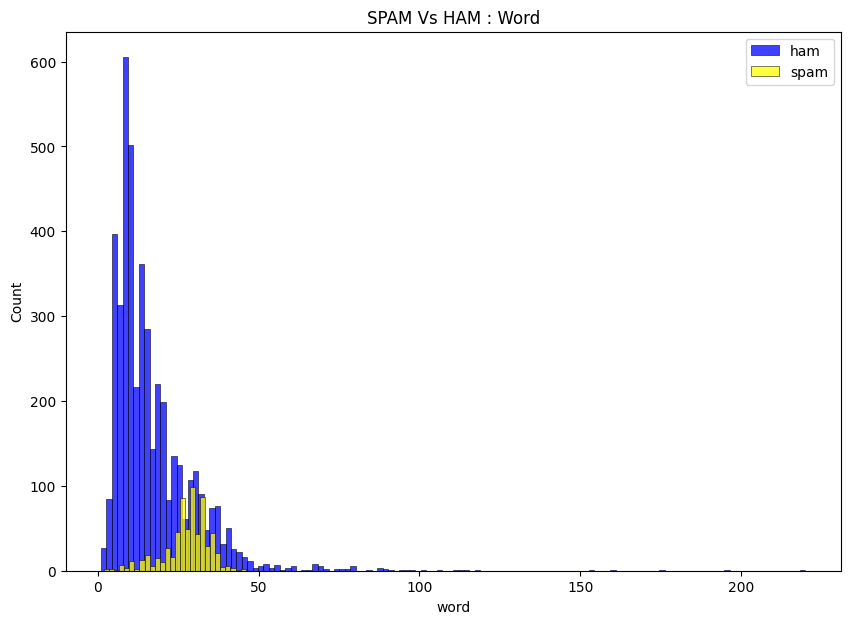

In [58]:
plt.figure(figsize=(10,7))
sns.histplot(df[df["output"]==0]["word"],label= "ham",color="blue")
sns.histplot(df[df["output"]==1]["word"],label= "spam",color = "yellow")
plt.title("SPAM Vs HAM : Word")
plt.legend()
plt.show()

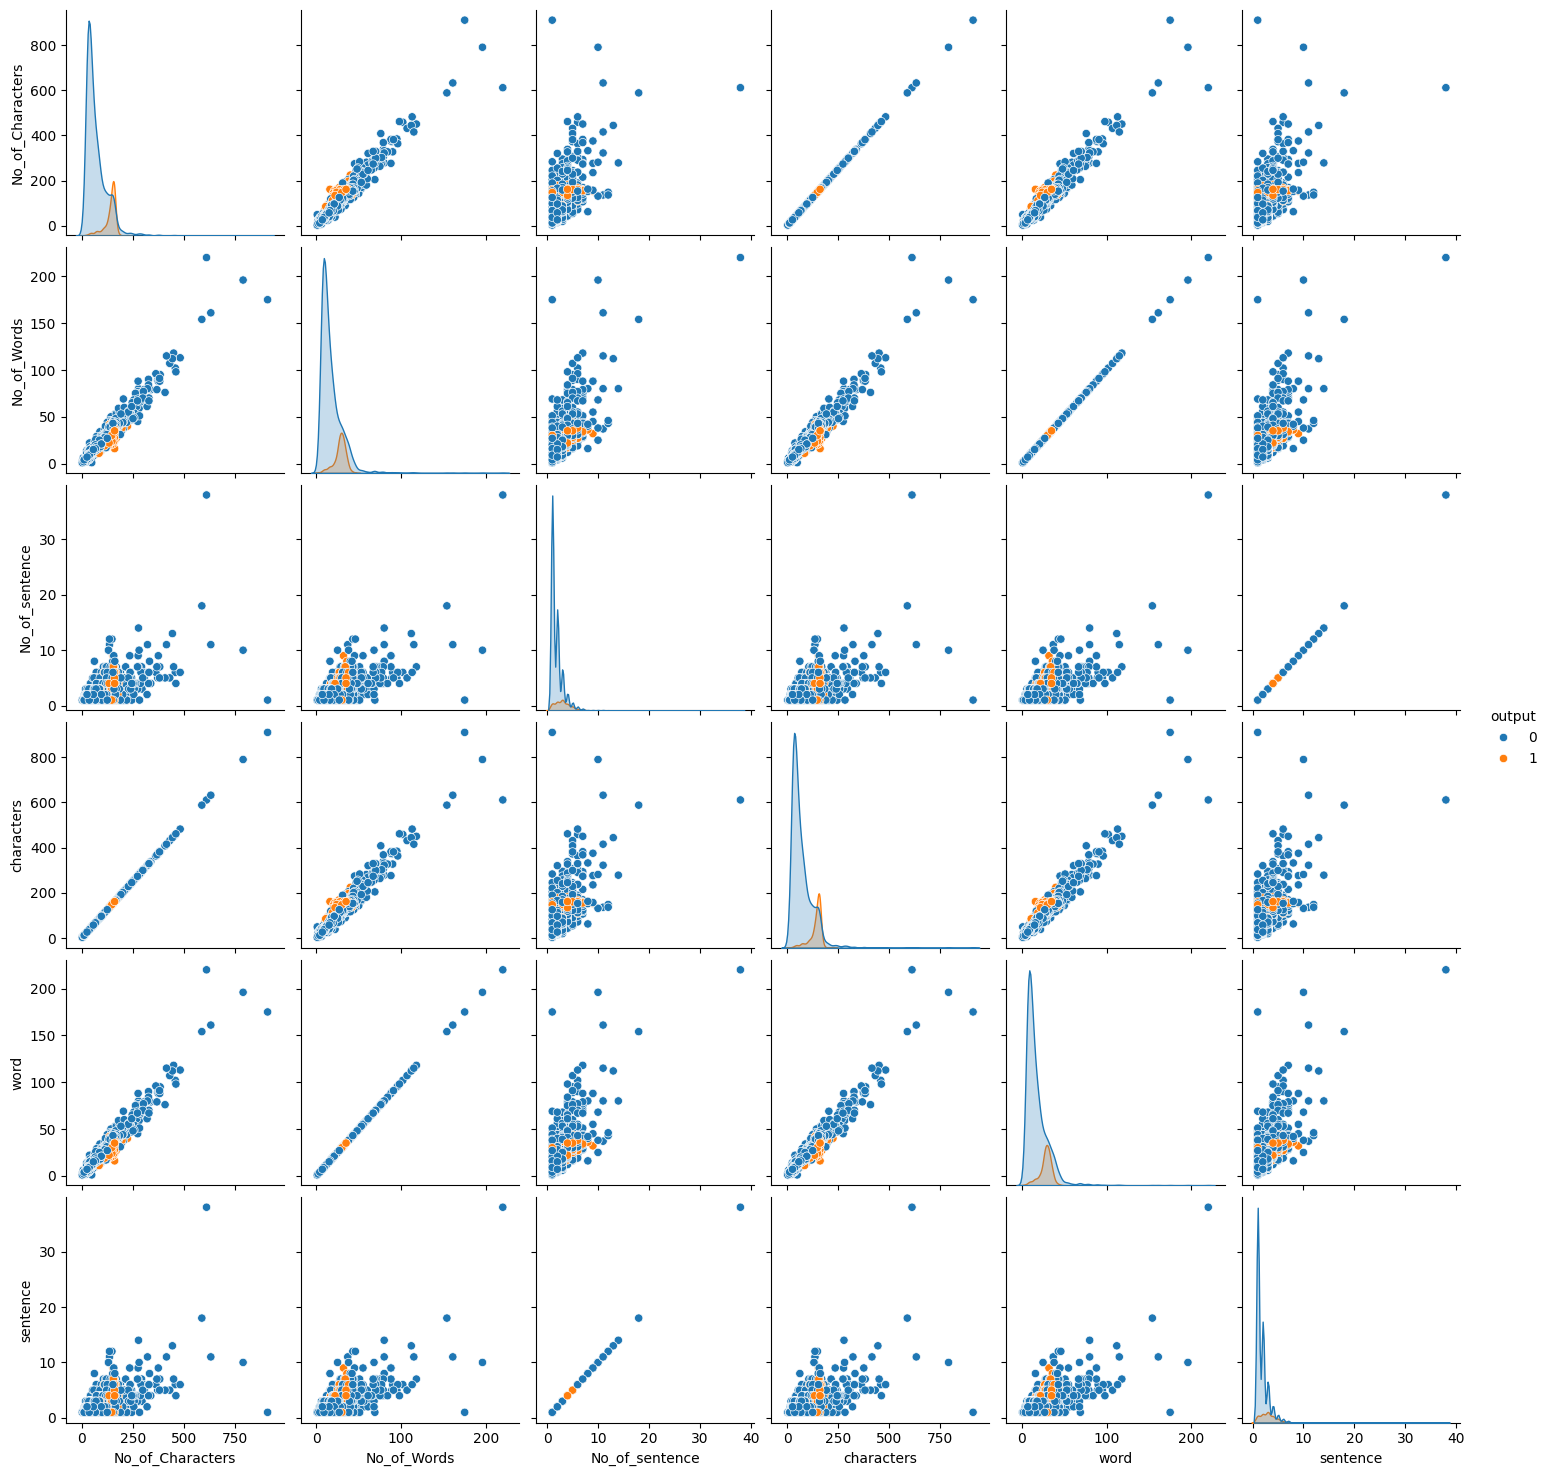

In [59]:
sns.pairplot(df,hue="output")

In [60]:
df.corr()

,output,No_of_Characters,No_of_Words,No_of_sentence,characters,word,sentence
output,1.000000,0.384717,0.262912,0.263939,0.384717,0.262912,0.263939
No_of_Characters,0.384717,1.000000,0.965760,0.624139,1.000000,0.965760,0.624139
No_of_Words,0.262912,0.965760,1.000000,0.679971,0.965760,1.000000,0.679971
No_of_sentence,0.263939,0.624139,0.679971,1.000000,0.624139,0.679971,1.000000
characters,0.384717,1.000000,0.965760,0.624139,1.000000,0.965760,0.624139
word,0.262912,0.965760,1.000000,0.679971,0.965760,1.000000,0.679971
sentence,0.263939,0.624139,0.679971,1.000000,0.624139,0.679971,1.000000


In [75]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


In [76]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [77]:
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature
X.dtype

dtype('float64')

In [79]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["output"] = label_encoder.fit_transform(data["output"])

In [80]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["output"]
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [83]:
from sklearn.model_selection import cross_val_score

# Cossvalidation
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))


NaiveBayes: 0.962856 
RandomForest: 0.974267 
KNeighbours: 0.913083 
SVC: 0.972810 


In [85]:
from sklearn import metrics

# Model Evaluation
# Creating lists of various scores
precision = []
recall = []
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    # Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)


In [86]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [88]:
from matplotlib.colors import ListedColormap

cmap2 = ListedColormap(["#E2CCFF", "#E598D8"])
Results.style.background_gradient(cmap=cmap2)


,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.745614,0.854271,0.975728,0.997815
RandomForest,0.989474,0.824561,0.899522,0.975728,0.997815
KNeighbours,1.000000,0.280702,0.438356,0.975728,0.997815
SVC,0.978495,0.798246,0.879227,0.975728,0.997815
